In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tfidf-pickle-file/tfidf.pkl
/kaggle/input/suicide-watch/Suicide_Detection.csv
/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl


In [2]:
from wordcloud import WordCloud
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install neattext
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from tensorflow.keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.6 MB/s eta 0:00:00


In [3]:
sns.set_palette('pastel')


In [4]:
data=pd.read_csv('../input/suicide-watch/Suicide_Detection.csv')
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [5]:
data = data.drop('Unnamed: 0',axis=1)

In [6]:
data = data.sample(n=50000, random_state=21)

In [7]:
data['class'].value_counts()

non-suicide    25043
suicide        24957
Name: class, dtype: int64

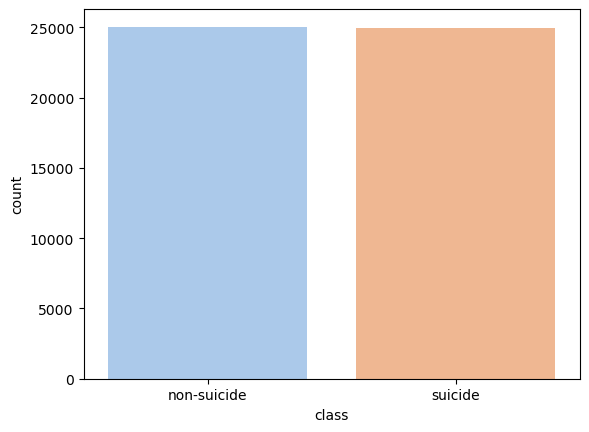

In [8]:
sns.countplot(x ='class', data = data)
plt.show()

In [9]:
data['class'].value_counts().index.values

array(['non-suicide', 'suicide'], dtype=object)

## Split DataSet


In [10]:
train_data,test_data=train_test_split(data,test_size=0.30,random_state=21)

## Visualizations

In [11]:
train_data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

## Data Cleaning

In [12]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
#         print(sent.shape)
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [13]:
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

100%|██████████| 15000/15000 [00:01<00:00, 11687.49it/s]


In [14]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [15]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

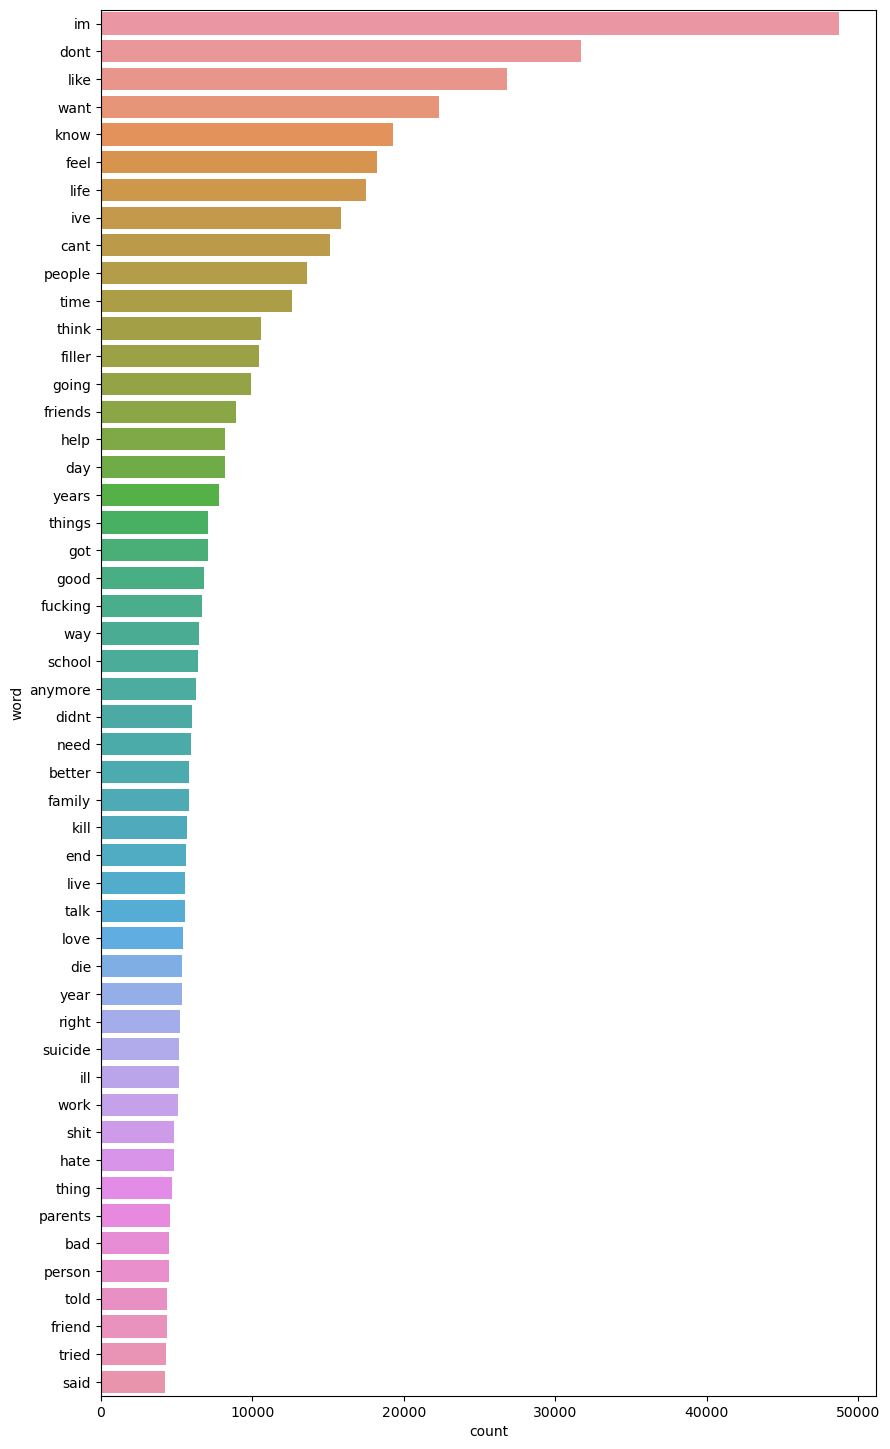

In [16]:
plt.figure(figsize=(10,18))
sns.barplot(x='count',y='word',data=word_freq.iloc[:50])
plt.show()

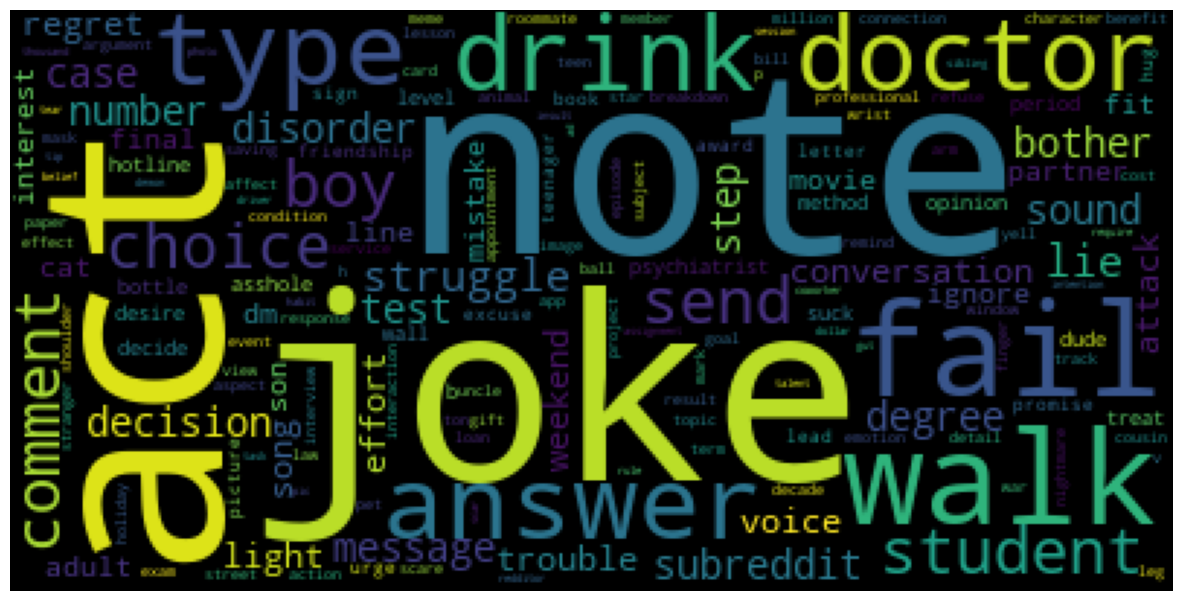

In [17]:
feature_names=word_freq['word'].values
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(wc)

## Text Pre-processing

In [18]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=50)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [19]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

## Glove Embeddings

In [20]:
# glove_embedding={}
with open('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [21]:
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [22]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

## Model Building

In [23]:
model=Sequential()
model.add(Input(shape=(50,)))
model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

In [24]:
r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=256,callbacks=[early_stop,reducelr])

Epoch 1/20
137/137 [==============================] - 13s 73ms/step - loss: 0.5536 - accuracy: 0.7251 - val_loss: 0.3702 - val_accuracy: 0.8495 - lr: 0.1000
Epoch 2/20
137/137 [==============================] - 9s 66ms/step - loss: 0.3555 - accuracy: 0.8521 - val_loss: 0.3037 - val_accuracy: 0.8759 - lr: 0.1000
Epoch 3/20
137/137 [==============================] - 9s 69ms/step - loss: 0.3028 - accuracy: 0.8753 - val_loss: 0.3320 - val_accuracy: 0.8603 - lr: 0.1000
Epoch 4/20
137/137 [==============================] - 9s 65ms/step - loss: 0.2809 - accuracy: 0.8867 - val_loss: 0.2677 - val_accuracy: 0.8956 - lr: 0.1000
Epoch 5/20
137/137 [==============================] - 9s 68ms/step - loss: 0.2660 - accuracy: 0.8924 - val_loss: 0.2558 - val_accuracy: 0.8973 - lr: 0.1000
Epoch 6/20
137/137 [==============================] - 9s 69ms/step - loss: 0.2525 - accuracy: 0.8973 - val_loss: 0.2664 - val_accuracy: 0.8921 - lr: 0.1000
Epoch 7/20
137/137 [==============================] - 10s 75ms/

## Model Evaluation

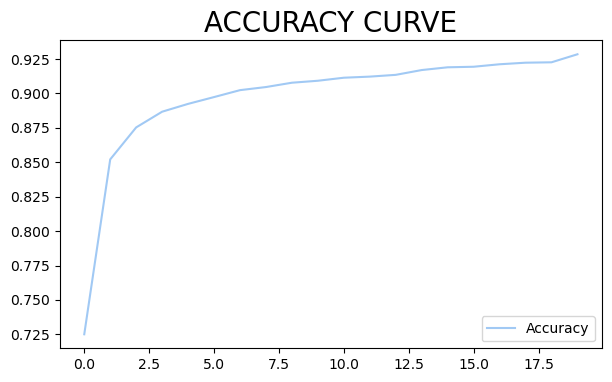

In [25]:
plt.figure(figsize=(7,4))
plt.plot(r.history['accuracy'], label="Accuracy")
# plt.plot(r.history['val_accuracy'], label="Val_Accuracy")
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.legend(loc='lower right')
plt.show()

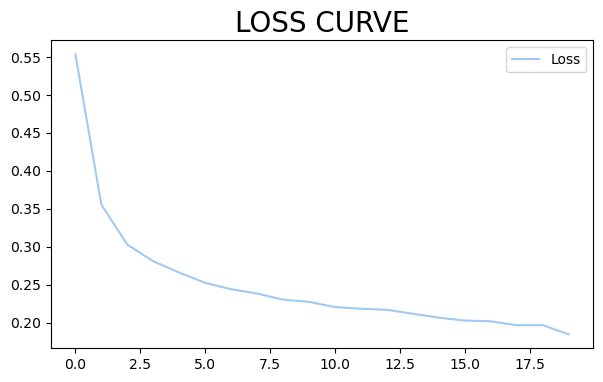

In [26]:
plt.figure(figsize=(7,4))
plt.plot(r.history['loss'], label="Loss")
# plt.plot(r.history['val_loss'], label="Val_Loss")
plt.title('LOSS CURVE',fontdict={'size':20})
plt.legend(loc='upper right')
plt.show()

In [27]:
print('TESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(test_output,(model.predict(test_text_pad) > 0.5).astype("int32"),
                            target_names=lbl_target.inverse_transform([0,1])))

print('TRAINING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(train_output,(model.predict(train_text_pad) > 0.5).astype("int32"),
                           target_names=lbl_target.inverse_transform([0,1])))

TESTING DATA CLASSIFICATION REPORT 
 

469/469 [==============================] - 5s 9ms/step
              precision    recall  f1-score   support

 non-suicide       0.92      0.92      0.92      7594
     suicide       0.92      0.91      0.92      7406

    accuracy                           0.92     15000
   macro avg       0.92      0.92      0.92     15000
weighted avg       0.92      0.92      0.92     15000

TRAINING DATA CLASSIFICATION REPORT 
 

1094/1094 [==============================] - 10s 9ms/step
              precision    recall  f1-score   support

 non-suicide       0.93      0.93      0.93     17449
     suicide       0.93      0.93      0.93     17551

    accuracy                           0.93     35000
   macro avg       0.93      0.93      0.93     35000
weighted avg       0.93      0.93      0.93     35000



## Conclusion

### This model gives Training Accuracy of 95% and Testing Accuracy of 93%.

In [28]:
import re

# Define the tokenizer and max length for input sequences
tokenizer = Tokenizer()
max_length = 50

# Load the pre-trained embedding matrix
# embedding_matrix = ... # Define the embedding matrix here

# Load the pre-trained model
# model = ... # Define the model here

def predict_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove numbers and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Tokenize the text
    tokens = tokenizer.texts_to_sequences([text])
    
    # Pad the tokenized sequence to the max length
    cleaned_text = pad_sequences(tokens, maxlen=max_length, padding='post')
    
    prediction = model.predict(cleaned_text)[0][0]
    
    return prediction
    # Return the prediction (as a string)
#     if prediction > 0.5:
#         return 'positive'
#     else:
#         return 'negative'




In [29]:
print(predict_text('i want to die as soon as possible and i am done '))

1/1 [==============================] - 0s 28ms/step
0.32984522
